In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


# Load Data

## reference hypercube

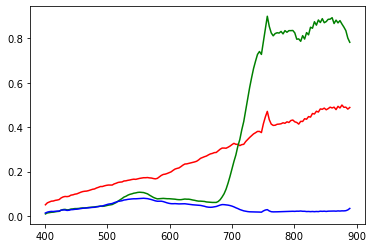

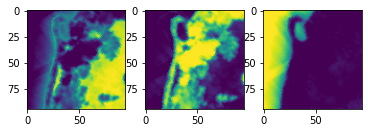

In [2]:
dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0], color='r')
plot(wavelength, spectra[1], color='g')
plot(wavelength, spectra[2], color='b')
plt.show()
figure(2)
subplot(1,3,1)
imshow(a_map[:,:,0])
subplot(1,3,2)
imshow(a_map[:,:,1])
subplot(1,3,3)
imshow(a_map[:,:,2])

In [3]:
a_map.shape

(95, 95, 3)

In [4]:
hypercube.shape

(95, 95, 156)

In [5]:
spectra.shape

(3, 156)

## Create Hypercube

Here, the sythentic hypercube is not used, it just gives a base line noiseless hypercube.

In [ ]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube, wavelength

In [ ]:
hypercube_noiseless,wavelength = create_sythentic_hypercube(a_map, spectra, wavelength)

In [ ]:
hypercube_noiseless.shape

In [ ]:
wavelength.shape

The original hypercube contains noise, so it is not exactly the same as the synthetic hypercube

In [ ]:
pos = where(a_map[:,:,2]>0.9999999999999999)
y = pos[0]
x = pos[1]
plot(wavelength, mean(hypercube_noiseless[y, x, :], axis=0), color = 'k')
plot(wavelength, mean(hypercube[y, x, :], axis=0), color = 'r')
plt.show()

Unmix the original hypercube, it estimates approximately the lowest unmixing error we can have.

In [6]:
'''cut it to save time '''
a_map = a_map[20:60,20:60,:]
hypercube = hypercube[20:60,20:60,:]

In [7]:
N,M,Q = hypercube.shape
predicted = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,Q)), spectra) # (N*M x P)

# Take RMS difference between true abundance map and computed.
accuracy = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted)**2))
print(accuracy)

predicted = predicted.reshape((N,M,3))

0.20706443300296


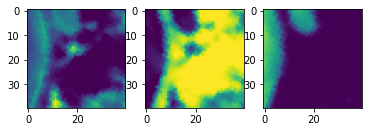

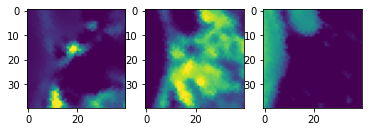

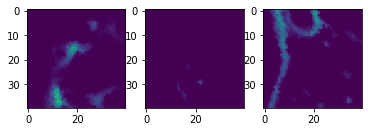

In [8]:
figure(1)
subplot(1,3,1)
imshow(a_map[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map[:,:,2], vmin=0, vmax=1)

figure(2)
subplot(1,3,1)
imshow(predicted[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(predicted[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(predicted[:,:,2], vmin=0, vmax=1)

figure(3)
subplot(1,3,1)
imshow(predicted[:,:,0]-a_map[:,:,0], vmin=0, vmax=0.5)
subplot(1,3,2)
imshow(predicted[:,:,1]-a_map[:,:,1], vmin=0, vmax=0.5)
subplot(1,3,3)
imshow(predicted[:,:,2]-a_map[:,:,2], vmin=0, vmax=0.5)

## Our Optimal MSFA

### Find Optimal MSFA

In [9]:
def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses, normalise to 1
    #d_lmbda = (wavelength[-1]-wavelength[0]) / (len(wavelength) - 1)
    #filters = [(d_lmbda/((bandwidths[i]/2.355) * sqrt(2.*pi))) * exp(-0.5*((wavelength - center_wavelengths[i])/(bandwidths[i]/2.355))**2) for i in range(len(center_wavelengths))]
    
    filters = [exp(-0.5*((wavelength - center_wavelengths[i])/(bandwidths[i]/2.355))**2) for i in range(len(center_wavelengths))]
    for i,f in enumerate(filters):
        filters[i] = filters[i] / filters[i].sum()
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    
    predicted[predicted>1] = 1
    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    if isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [10]:
def increment_position(hypercube,abundance_map, endmembers, wavelength, score, inc, pmax, pmin, score_function, bands, bws, i, j, verbose=False):
    '''
    Helper function to optimize the central wavelengths of spectral bands. Adjusts the center wavelength in one direction
    and compares to the previous result.
    '''
    if bands[i,j] >= pmax:
        bands[i,j] = pmax
        if verbose:
            print("Band location is at the maximum limit.")
        return score, bands, bws
    elif bands[i,j] <= pmin:
        bands[i,j] = pmin
        if verbose:
            print("Band location is at the minimum limit.")
        return score, bands, bws
    else:
        bands[i,j] += inc
        new_score = score_function(hypercube,abundance_map, endmembers, wavelength, bands[i], bws[i])
        if new_score < score:
            if verbose:
                print("Position adjustment resulted in previous score of %.3f improving to %.3f." %(score, new_score))
            return increment_position(hypercube,abundance_map, endmembers, wavelength, new_score, inc, pmax, pmin, score_function, bands, bws, i, j,verbose=verbose)
        else:
            if verbose:
                if inc < 0:
                    print("Convergence reached for band position adjustment in negative direction.")
                else:
                    print("Convergence reached for band position adjustment in positive direction.")
            bands[i,j] -= inc
            return score, bands, bws
        
def increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, inc, bmax, bmin, score_function, bands, bws, i, j,verbose=False):
    '''
    Helper function to optimize the bandwidths of spectral bands. Adjusts the bandwidth in one direction
    and compares to the previous result.
    '''
    if bws[i,j] >= bmax:
        bws[i,j] = bmax
        if verbose:
            print("Bandwidth is at the maximum limit.")
        return score, bands, bws
    elif bws[i,j] <= bmin:
        bws[i,j] = bmin
        if verbose:
            print("Bandwidth is at the minimum limit.")
        return score, bands, bws
    else:
        bws[i,j] += inc
        new_score = score_function(hypercube,abundance_map, endmembers, wavelength, bands[i], bws[i])
        if new_score < score:
            if verbose:
                print("Bandwidth adjustment resulted in previous score of %.3f improving to %.3f." %(score, new_score))
            return increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, new_score, inc, bmax, bmin, score_function, bands, bws, i, j,verbose=verbose)
        else:
            if verbose:
                if inc < 0:
                    print("Convergence reached for bandwidth adjustment in negative direction.")
                else:
                    print("Convergence reached for bandwidth adjustment in positive direction.")
            bws[i,j] -= inc
            return score, bands, bws

def refine_position(hypercube,abundance_map,endmembers,wavelength, bands, bws, maxiter=20,score_function=compute_unmixing_accuracy,pstep=2,verbose=False):
    '''
    Helper function to optimize the central wavelengths of spectral bands. This function effectively conducts a gradient
    descent optimization to adjust the center wavelength until a local minimum is reached.
    '''
    old_ps = zeros_like(bands) # Empty array to track changes
    n = 0 # index of iterations

    # First, iterate through positions
    while any(old_ps != bands) and n < maxiter:
        old_ps = bands.copy()
        n += 1
        if verbose:
            print("Performing position refinement iteration number %d." %n)
                    
        for i, band in enumerate(bands):
            score = score_function(hypercube,abundance_map, endmembers, wavelength, band, bws[i])

            for j, p in enumerate(band):
                if verbose:
                    print("Refining position of band %.1f nm. Beginning score of %.3f." % (p,score))
                #score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength,score, pstep, p+30, p-30, score_function, bands, bws, i ,j,verbose=verbose)
                #score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength, score, -1*pstep, p+30, p-30, score_function, bands, bws, i, j,verbose=verbose)
                score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength,score, pstep, wavelength[-1]+10, wavelength[0]-10, score_function, bands, bws, i ,j,verbose=verbose)
                score, bands, bws = increment_position(hypercube,abundance_map, endmembers, wavelength, score, -1*pstep, wavelength[-1]+10, wavelength[0]-10, score_function, bands, bws, i, j,verbose=verbose)
                
    if verbose:
        print("Final band locations for this loop are ",bands)

    return bands, bws

        
def refine_bandwidth(hypercube,abundance_map,endmembers,wavelength, bands, bws , maxiter=20,score_function=compute_unmixing_accuracy,bstep=2,bw_max=50.,bw_min=20.,verbose=False):              
    '''
    Helper function to optimize the bandwidth of spectral bands. This function effectively conducts a gradient
    descent optimization to adjust the bandwidth until a local minimum is reached.
    '''
    old_bws = zeros_like(bws) # empty array to track changes
    n = 0 # index of iterations
            
    # Now, through bandwidths
    while any(old_bws != bws) and n < maxiter:
        old_bws = bws.copy()
        n += 1
        if verbose:
            print("Performing bandwidth refinement iteration number %d." %n)
        for i, band in enumerate(bands):
                   
            score = score_function(hypercube,abundance_map, endmembers, wavelength, band, bws[i])
            for j, z in enumerate(band):
                if verbose:
                    print("Refining bandwidth of band %.1f nm. Beginning score of %.3f." % (z, score))
                score, bands, bws  = increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, bstep, bw_max, bw_min, score_function, bands, bws, i, j,verbose=verbose)
                score, bands, bws  = increment_bandwidth(hypercube,abundance_map, endmembers, wavelength, score, -1*bstep, bw_max, bw_min, score_function, bands, bws, i, j,verbose=verbose) # lazy way to check both directions
                
    if verbose:
        print("Final bandwidths for this loop are ",bws)
    return bands, bws

In [11]:
def optimize_spectral_bands(hypercube, abundance_map, endmembers, wavelength, N_filters, bw_max=50., bw_min=10., bstep=2., pstep=2.,random_sampling=False, n_iter=1000, loops=10,merit_function="unmixing",verbose=False):
        '''
        Optimize the spectral band position and bandwidth. Begins by stochastically sampling the 
        space of possible options. The top 5 results are then retained and a gradient descent
        approach is taken to convergene on the optimal result. The function returns the best 
        result, along with the merit function score.

        Inputs:
            hypercube (N X M x Q array) - 3D synthetic hypercube.

            abundance_map (N x M x P array)- 3D abundance map of target. Each channel in L corresponds to the
                 abundance (between 0 and 1) of the spectral signature in the spectra array. 

            endmembers (P x Q array) - Array of endmember signals to unmix.

            wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
                response arrays.
                
            N_filters (int): Maximum number of spectral bands. (currently fixed)

            bw_max (optional float, default=50): Maximum allowable bandwidth in nanometers for a spectral band.

            bw_min (optional float, default=5): Minimum allowable bandwidth in nanometers for a spectral band.

            bstep (optional float, default=2): Step-size in nanometers to take when optimzing spectral bands.

            random_sampling (optional Boolean, default=False)

            n_iter (optional int, default=10000): Number of iterations for the stochastic sampling step.
            
            loops (optinal int, default=10): Number of gradient descent optimization loops.

            merit_function (optional string, default="unmixing"): Merit function to use in
                the optimization. The options are:
                   'unmixing': Spectral unmixing accuracy. Minimizes the root-sum-squared difference
                       between the true endmember abundance and that obtained by NNLS unmixing.

            verbose (optional boolean, default=False): Print out relevant information
              as optimization proceeds. TODO: Set verbosity levels of 0-4 for different amounts
              of output information.

        Returns:
            center_wavelengths (1 x N_filters array) - Array describing center wavelengths of optimal
                filter set.
            
            bandwidths (1 x N_filters array) - Array describing bandwidths of optimal
                filter set.
        '''
        # Initial bandwidth will be halfway between max and min
        bw_init = (bw_max - bw_min)/2.
        
        # Generate empty arrays for stochastic optimization step.
        band_list = zeros((n_iter,N_filters))
        dist_list = zeros(n_iter)

        # TODO: Implement other merit functions
        if merit_function == "unmixing":
            score_function = compute_unmixing_accuracy
            
        if random_sampling == True:
            # for reproducibility, set random seed to 0
            random.seed(0)
            
            if verbose:
                print("Beginning stochastic optimization of band position with %d iterations." %n_iter)
            for i in range(n_iter):
                if verbose and not i % 100:
                    print("Stochastic optimization iteration %d." %i)
                # Generate the random sampling of spectral bands over wavelegnth range
                #sbands = randsamp(range(int(wavelength[0]),int(wavelength[-1]), int(bw_init*2)), N_filters)
                # for 4
                sbands = random.sample(range(int(wavelength[0]),int(wavelength[-1]), int(bw_init*2)), N_filters)
                

                dist = score_function(hypercube,abundance_map, endmembers, wavelength, sbands, ones(N_filters)*bw_init)
                dist_list[i] = dist
                band_list[i,:] = sbands

            # Sort according to accuracy
            dist_sorted = dist_list[dist_list.argsort()]
            bands_sorted = band_list[dist_list.argsort()]

            bands = bands_sorted[:5] # take top 5
            bws = ones_like(bands)*bw_init
            if verbose:
                print("Stochastic optimization complete. Initializing gradient descent with top 5 candidates.")
                print(bands)
        else:
            # Evenly space the array
            if verbose:
                print("Initializing with evenly spaced band array.")
            bands = linspace(wavelength[0]+bw_init*2,wavelength[-1]-bw_init*2,N_filters).reshape(1,N_filters)
            bws = ones_like(bands)*bw_init
                
        if verbose:
            print("Beginning gradient-based optimization of bandwidth.")
            
        for k in range(loops):
            if verbose:
                print("Performing iteration loop %d of %d." %(k, loops))
            bands, bws = refine_position(hypercube,abundance_map,endmembers,wavelength,bands, bws, score_function=score_function, pstep=2.,verbose=verbose)
            bands, bws = refine_bandwidth(hypercube,abundance_map,endmembers,wavelength,bands, bws,score_function=score_function, bw_max=50., bw_min=10., bstep=2.,verbose=verbose)

        return bands, bws

In [12]:
# merit function: unmixing
bands_3,bws_3 = optimize_spectral_bands(hypercube,a_map,spectra,wavelength,3,merit_function="unmixing", 
                                        verbose=False,random_sampling=True)

In [13]:
print(bands_3)
print(bws_3)
for i in range(5):
    print(bands_3[i])
    print(bws_3[i])
    print(compute_unmixing_accuracy(hypercube, a_map, spectra, wavelength, bands_3[i], bws_3[i], return_predicted=False))

[[899. 571. 579.]
 [899. 579. 571.]
 [571. 579. 899.]
 [579. 571. 899.]
 [571. 899. 579.]]
[[12. 10. 50.]
 [12. 50. 10.]
 [10. 50. 12.]
 [50. 10. 12.]
 [10. 12. 50.]]
[899. 571. 579.]
[12. 10. 50.]
0.192409349246408
[899. 579. 571.]
[12. 50. 10.]
0.192409349246408
[571. 579. 899.]
[10. 50. 12.]
0.1924093492463931
[579. 571. 899.]
[50. 10. 12.]
0.1924093492463931
[571. 899. 579.]
[10. 12. 50.]
0.192409349246408


### On Samson

In [14]:
def filter_response(cw, bws):
    '''
    Helper function to generate NORMALISED filter response
    '''
    filters = array([exp(-0.5*((wavelength - cw[i])/(bws[i]/2.355))**2) for i in range(len(cw))])
        
    return filters

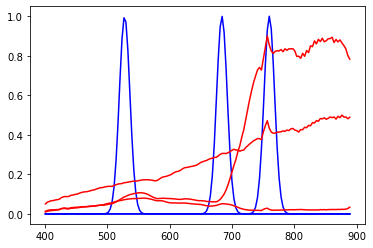

In [42]:
set_3 = filter_response([528., 684., 760.], [20,20,20])

plot(wavelength, set_3.T,'b')
plot(wavelength, spectra.T,'r')

### Spatial Arrangement

In [16]:
def sample_hypercube_MSFA(hypercube, pattern_dims, filter_responses, wavelength, full_res=False):
    '''
    Generate raw MSFA data from a synthetic hypercube.
    
    Inputs:
        hypercube (N x M x Q) - 3D synthetic hypercube.
        
        pattern_dims ((my, mx)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
            provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.
        
        filter_responses (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
            filter in the MSFA. A total of J different filter responses of the macropixel
            should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
            e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube. Filter spectral responses must also be provided on this axis.
            
        full_res (optional Boolean) - Set to true to generate a reference image with no spatial sampling
            effects from the MSFA pattern pixellation. Use to generate "perfect" spatial image.
    
    Outputs:
        raw_MSFA (N x M x J) - Series of 2D images showing the collected signal for
            a given channel.
    '''
    my,mx = pattern_dims
    N,M,Q = hypercube.shape
    J = filter_responses.shape[0]
    
    if (not mx*my == J) and (full_res == False):
        print('The filter response array does not have the correct number of members')
        return
    
    raw_MSFA = zeros((N,M,J))
    n = 0
    if full_res == False:
        for i in range(mx):
            for j in range(my):
            
                MSFA = zeros((N,M))
                filter_response = filter_responses[n]

                MSFA[j::my,i::mx] = sum(hypercube[j::my,i::mx,:]*filter_response,axis=2)
            
                raw_MSFA[:,:,n] = MSFA
                n+=1
    else:
        for n in range(J):
            MSFA = zeros((N,M))
            filter_response = filter_responses[n]
            MSFA = sum(hypercube*filter_response,axis=2)
            raw_MSFA[:,:,n] = MSFA

    return raw_MSFA, wavelength

In [17]:
def compute_H(my,mx):
    '''
    Caclulates the bilinear interpolation filter for a given mosaic.
    
    Inputs:
        mx -  Horizontal array dimension of MSFA macro-pixel.
        
        my - Vertical array dimension of MSFA macro-pixel.
        
    Outputs:
        H (mx*2-1 x my*2-1) - Weighted, normalized bilinear interpolation filter.
    '''

    # Initialize empty array
    H = zeros((int(my)*2-1,int(mx)*2-1))
    
    # Define un-normalized filter
    for i in range(my+1):
        H[i] = r_[arange(1,mx+1),arange(1,mx)[::-1]]*(i+1)

    for i in range(my):
        H[my*2-2-i] = r_[arange(1,mx+1),arange(1,mx)[::-1]]*(i+1)
        
    # Normalize
    H /= H.max()

    return H

In [18]:
def WB(I,H):
    '''
    Weighted bilinear interpolation.
    
    Inputs: 
        I (N x M array) - Individual channel image from MSFA
        
        H (2D array) - Weighted, normalized bilinear interpolation filter. Calculated from 
            mosaic dimensions
        
    Outputs:
        I_wb - Interpolated channel image.
        
    '''
    I_wb = convolve2d(I,H,mode='same')
    return I_wb

In [19]:
def all_filters_present(avail_fils,N_filters):
    '''
    Helper function to make sure that only mosaic patterns including all available filters are used. This comes into play when using fewer filters than mosaic pattern locations.
    '''
    combos = []
    for total in itertools.product(avail_fils, repeat=N_filters):
        valid = 1
        for i in avail_fils:
            if not i in total:
                valid = 0
        if valid == 1:
            combos.append(total)
        
    return combos

In [20]:
def RMS_pixel_difference(im,ref):
    '''
    Total RMS error between an image (im) and reference (ref). Used as a merit function.
    
    Inputs:
        im (N x M x L array) - Image to test quality.
    
        ref (N x M x L array) - Reference to compare test image to.
    
    Outputs:
    
        rms (float): RMS pixel difference between input image and a reference.
    
    '''
    
    # How to account for scaling between channels?
    rms = sqrt( mean((im-ref)**2))

    return rms

In [21]:
def MSI_criteria(demosaicked_MSI, abundance_map, endmembers, wavelength, filter_responses, unmixing_method, return_predicted=False):
    '''
    Function to compute unmixing accuracy from MSI.
    
    Inputs:
        demosaicked_MSI (N X M x L) - MSI.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target.
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        filter_responses (1 x L array) - Array or list of filters.
        
        unmixing_method- whether NNLS, UCLS or FCLS
        
        return_predicted - whether return predicted abundance map
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,L = demosaicked_MSI.shape
    
    P = len(endmembers)
    
    # Final signals
    MSI_sig = demosaicked_MSI.reshape((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filter_responses):       
        
        # Iterate through each endmember
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q

    if unmixing_method == 'NNLS':
        predicted = abundance_maps.amaps.NNLS(MSI_sig, endmember_sig) # (N*M x P)
    elif unmixing_method == 'UCLS':
        predicted = abundance_maps.amaps.UCLS(MSI_sig, endmember_sig) # (N*M x P)
    else:
        predicted = abundance_maps.amaps.FCLS(MSI_sig, endmember_sig) # (N*M x P)

    predicted[predicted>1] = 1 # max abundance map = 1
    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [31]:
def generate_correlation_matrix(hypercube, filter_responses, wavelength, verbose=False):
    '''
    Function to generate the correlation matrix between different
    channels in the MSFA. Computes the correlation between the central 
    wavelengths of each filter for every unique spectral response
    found in the target. Then, takes a weighted average of these
    correlations depending on how prevalent the particular spectral
    response is. Correlation matrix should be calculated before
    noise is added to the system.
    
    Inputs:
        hypercube (N x M x Q) - 3D synthetic hypercube.
        
        filter_responses (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
            filter in the MSFA. A total of J different filter responses of the macropixel
            should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
            e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube. Filter spectral responses must also be provided on this axis.
        
        verbose (optional Boolean, default=False) - Set to true to get updates on processing
        
    Outputs:
        corr (J x J) - Correlation matrix between central wavelengths 
    '''
    
    # Normalize spectral data per pixel to 
    N,M,Q = hypercube.shape
    hsi_norm = hypercube.max(axis=2)
    hsi_norm[hsi_norm==0] = 1.

    responses = []
    num_responses = []

    for i in range(N):
        if verbose and not i%100:
            print('Processing Row %d' %i)
        for j in range(M):
            norm_sig = hypercube[i,j]/hsi_norm[i,j]
            index_array = [all(norm_sig == resp) for resp in responses]
            if any(index_array):
                num_responses[argmax(index_array)]+=1
                continue
            else:
                responses.append(norm_sig)
                num_responses.append(1)
                
    filter_maxima = [argmax(f) for f in filter_responses]

    m_sigs = []
    for r in responses:
        max_signal = r[filter_maxima]
        m_sigs.append(max_signal)
        
    covariance = cov(m_sigs, fweights = num_responses, rowvar=False)
    
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [37]:
def binary_mask_MSFA(N,M,mx,my,L):
    '''
    Function to create binary mask corresponding to "observed" pixels
    in a MSFA channel.
    
    Inputs: 
        N,M - MSFA image data dimensions
        
        mx -  Horizontal array dimension of MSFA macro-pixel.
        
        my - Vertical array dimension of MSFA macro-pixel.
        
        L - Filter number (reading order)
    
    Outputs:
        mask (N,M) - Binary mask for observed pixels of a given channel.
    '''
    # This is not very elegant...
    output = zeros((N,M))
    
    n = 0
    for i in range(mx):
        for j in range(my):
            if n == L:
                output[j::my,i::mx] = 1.
                return output
            else:
                n+=1

In [45]:
# Iterative spectral differences
def ISB(I, pattern_dims, corr, iteration=0,verbose=False):
    '''
    Iterative spectral differences algorithm for demosaicking.
    
    Inputs:
        I (N x M x J array) - MSFA raw data array with J different channels. 
        
        pattern_dims ((mx, my)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
                provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.
        
        corr (J x J array) - Correlation matrix describing spectral correlation
            between each filter. Used to determine maximum number of iterations
        
        iteration (int, default=0) - Iteration number, tracked outside of function.
        
        verbose (optional Boolean) - Set to true for status updates. 
        
    Outputs:
        demosaicked (N x M x L array) - Demosaicked MSFA data
    
    '''
    if verbose and not iteration % 10:
        print("Iteration %d" % iteration)
    
    N,M,channels = I.shape
    mx,my = pattern_dims
    
    Nab = exp(corr*3.) # Compute iterations per channel pair
    
    demosaicked = zeros_like(I)
    
    H = compute_H(mx,my)
    
    print('print(channels)',channels)
    
    # Reference - ch1
    for ch1 in range(channels):
        B1 = binary_mask_MSFA(N,M,mx,my,ch1)
        
        # Set output data to observed 
        demosaicked[:,:,ch1][B1==1.] = I[:,:,ch1][B1==1.]
        # Target - ch2
        for ch2 in range(channels):
            if ch1==ch2 or Nab[ch1,ch2]<=iteration:
                continue
            else:
                B2 = binary_mask_MSFA(N,M,mx,my,ch2)
                
                # Demosaicked channel A
                if iteration==0:
                    Ca = WB(I[:,:,ch1],H)
                else:
                    Ca = I[:,:,ch1]
                # Apply binary mask for target B
                # Subtract from observed to get difference
                # Apply bilinear interpolation
                Kab = WB(Ca*B2 - I[:,:,ch2]*B2,H)
                
                # 
                demosaicked[:,:,ch2][B1==1.] = (Ca - Kab)[B1==1.]

    return demosaicked

In [39]:
def spatial_optimization_MSFA(hypercube,wavelength,pattern_dims, filters,demosaicking="WB", verbose=False):
        '''
        Full spatial optimization pipeline to determine the optimal filter
        pattern for a multispectral filter array given a synthetic hypercube
        target, and filter responses.
        
        Inputs:
            hypercube (N X M x Q) - 3D synthetic hypercube.
            
            wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
                response arrays.
            
            pattern_dims ((my, mx)) - Tuple of dimensions for macropixel. A 3x3 pixel would be
                provided as (3,3) whereas a 3x2 pixel is provided as (3,2), etc.

            filters (J x Q) - Normalized (max of 1) spectral response curves, or QE curves, for each 
                filter in the MSFA. A total of J different filter responses of the macropixel
                should be provided in reading order. J will equal the number of sub-pixels in the macro-pixel.
                e.g., px*py = J. Even if there is a duplicate filter, provide the same spectral response curve.
            
            verbose (optional): Set to true for status updates
            
        Outputs:
            pattern for the min unmixing error
            demosaicked images (without duplicated bands) for the min unmixing error
            demosaicked images (with duplicated bands) for the min unmixing error
            reference images for each band
            a list of unmixing error for each spatial arrangement
            a list of demosaicking rms error for each spatial arrangement
        '''
        # Total number of filters in the pattern
        N_filters = pattern_dims[1]*pattern_dims[0]#len(filters)
        # Available filters to place
        avail_fils = arange(len(filters))
        # pattern shape
        my,mx = pattern_dims
        
        # Iterate through every possible permutation of the filter arrangement
        best = inf
        pattern = []
        best_demosaicked = None
        best_demosaicked_MSI = None
        best_ref = None
        demo_err_list =[]
        accu_list = []

        filter_combos = all_filters_present(avail_fils,N_filters)
        for fil_set in filter_combos:
            
            if verbose == True:
                print(fil_set)
            # Re-organize filters appropriately
            f = array([filters[i] for i in fil_set])
                
            # Generate raw MSFA data
            raw, _ = sample_hypercube_MSFA(hypercube,pattern_dims,f,wavelength,full_res=False)

            # Generate perfect spatial reference
            ref,_ = sample_hypercube_MSFA(hypercube,pattern_dims,filters,wavelength,full_res=True)
   
             # Demosaic the raw MSFA data using iterative spectral differences
            if demosaicking == "WB":
                if verbose:
                    print("Using weighted bilinear interpolation for demosaicking.")
                H = compute_H(*pattern_dims)
                demosaicked = zeros_like(raw)
                for c in range(len(f)):
                    demosaicked[:,:,c] = WB(raw[:,:,c],H)
                
            else:
                #ISB need corr
                corr = generate_correlation_matrix(hypercube,filters,wavelength)
                if verbose:
                    print("Using iterative spectral differences with %i iterations" %int(exp(corr.max()*3.)))
                for iteration in range(int(exp(corr.max()*3.))):
                    demosaicked = ISB(raw,pattern_dims,corr, iteration=iteration,verbose=verbose)
    
            demosaicked_MSI = zeros_like(ref) # in the order of given filter set
            MSI_count = zeros(len(filters))

            for c in range(len(f)):
                demosaicked_MSI[:,:,fil_set[c]] = demosaicked_MSI[:,:,fil_set[c]] + demosaicked[:,:,c]
                MSI_count[fil_set[c]] += 1
                
            # average the duplicated bands
            demosaicked_MSI = demosaicked_MSI / MSI_count[newaxis, newaxis, :]
            
            
            # apply mask
            for c in range(len(f)):
                i = int(c / my) # in x direction
                j = c - i*my # in y direction
                demosaicked_MSI[j::my,i::mx,fil_set[c]] = ref[j::my,i::mx,fil_set[c]]

            m = RMS_pixel_difference(demosaicked_MSI, ref)
            # note that the edges of an image may not be well demosaicked
            accu = MSI_criteria(demosaicked_MSI[5:-5,5:-5,:], a_map[5:-5,5:-5,:], spectra, wavelength, filters, 'NNLS', return_predicted=False)
            demo_err_list.append(m)
            accu_list.append(accu)
            
            if verbose == True:
                print(m, accu)
                
            # the best pattern should give best unmixing accuracy
            if accu < best:
                best = accu
                pattern = fil_set
                best_demosaicked = demosaicked
                best_demosaicked_MSI = demosaicked_MSI
                best_ref = ref

        print("Optimal pattern is", pattern)
        return pattern, best_demosaicked_MSI, best_demosaicked, best_ref, demo_err_list, accu_list

WB

In [27]:
pattern_dims = (2,2)
verbose=True

set_3 = filter_response([899, 617, 559], [16, 18, 10])
pattern_3, demosaicked_MSI_3, demosaicked_3, ref_3, demo_err_3, accu_3  = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,set_3,demosaicking= "WB",verbose=True)


(0, 0, 1, 2)
Using weighted bilinear interpolation for demosaicking.
0.048612663636706424 0.21381103809311797
(0, 0, 2, 1)
Using weighted bilinear interpolation for demosaicking.
0.041248519831016364 0.21584590908946902
(0, 1, 0, 2)
Using weighted bilinear interpolation for demosaicking.
0.04182314854808402 0.2165994587619677
(0, 1, 1, 2)
Using weighted bilinear interpolation for demosaicking.
0.03556105426352892 0.21471803100715744
(0, 1, 2, 0)
Using weighted bilinear interpolation for demosaicking.
0.04253869325709251 0.2179252581711355
(0, 1, 2, 1)
Using weighted bilinear interpolation for demosaicking.
0.03856590625795621 0.2159004726033573
(0, 1, 2, 2)
Using weighted bilinear interpolation for demosaicking.
0.042874005830035804 0.21831957850941364
(0, 2, 0, 1)
Using weighted bilinear interpolation for demosaicking.
0.03920410277232602 0.21522920827640432
(0, 2, 1, 0)
Using weighted bilinear interpolation for demosaicking.
0.047529748803615775 0.21661179574542946
(0, 2, 1, 1)
Using

ISB

In [46]:
pattern_3, demosaicked_MSI_3, demosaicked_3, ref_3, demo_err_3, accu_3  = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims,set_3,demosaicking= "ISB",verbose=True)

(0, 0, 1, 2)
Using iterative spectral differences with 20 iterations
Iteration 0
print(channels) 4


IndexError: index 3 is out of bounds for axis 1 with size 3

In [28]:
len(demo_err_3)

36

In [29]:
sqrt(mean((a_map.reshape((40*40,3)))**2))

0.4969917980425887

0.21381103809311797
0.21858910734143694
0.2164608574375014
0.0010253402222852542


<BarContainer object of 36 artists>

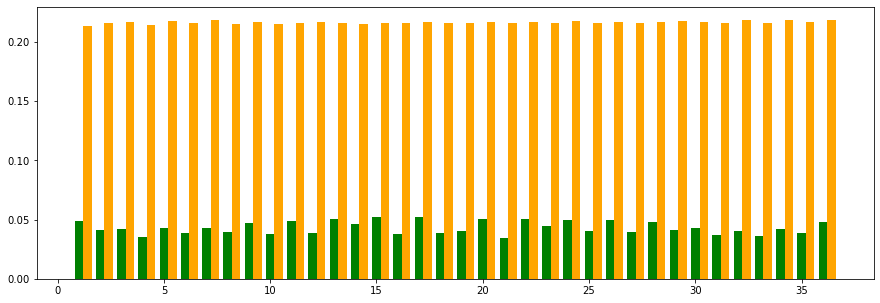

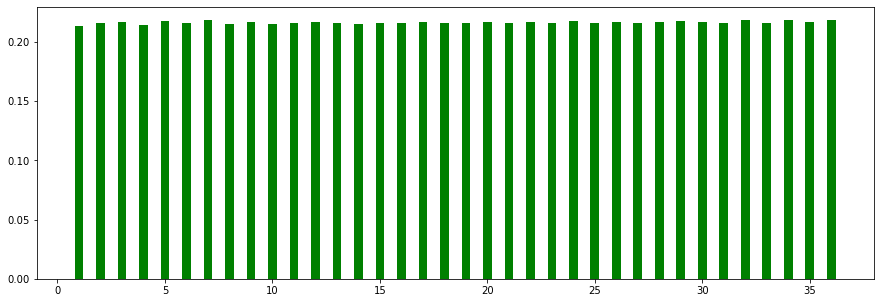

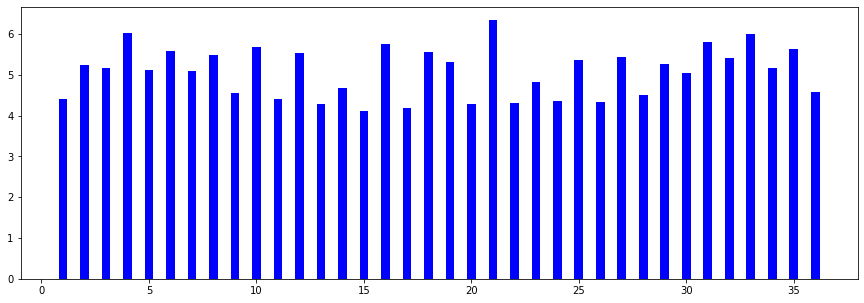

In [30]:
plt.figure(figsize=(15,5))
figure(1)
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]
xx = np.array(x)+0.4
plt.bar(x,demo_err_3,0.4,color="green")
plt.bar(xx,accu_3,0.4,color="orange")

plt.figure(figsize=(15,5))
figure(2)

plt.bar(x,accu_3,0.4,color="green")
print(amin(accu_3))
print(amax(accu_3))
print(mean(accu_3))
print(std(accu_3))


ratio = array(accu_3) / array(demo_err_3)
plt.figure(figsize=(15,5))
figure(3)
plt.bar(x,ratio,0.4,color="blue")

In [ ]:
_, a_map_predicted_3 = MSI_criteria(demosaicked_MSI_3[5:-5,5:-5,:], a_map[5:-5,5:-5,:], spectra, wavelength, set_3, 'NNLS', return_predicted=True)
figure(1)
subplot(1,3,1)
imshow(a_map[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map[:,:,2], vmin=0, vmax=1)

figure(2)
subplot(1,3,1)
imshow(a_map_predicted_3[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map_predicted_3[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map_predicted_3[:,:,2], vmin=0, vmax=1)

In [ ]:
pattern_dims = (2,2)
verbose=True
pattern_4, demosaicked_MSI_4, demosaicked_4, ref_4, demo_err_4, accu_4  = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims, set_4, verbose)
figure(1)
plot(demo_err_4)
figure(2)
plot(accu_4)
print(amin(accu_4))
print(amax(accu_4))
print(mean(accu_4))
print(std(accu_4))

In [ ]:
_, a_map_predicted_4 = MSI_criteria(demosaicked_MSI_4[5:-5,5:-5,:], a_map[5:-5,5:-5,:], spectra, wavelength, set_4, 'NNLS', return_predicted=True)
figure(1)
subplot(1,3,1)
imshow(a_map[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map[:,:,2], vmin=0, vmax=1)

figure(2)
subplot(1,3,1)
imshow(a_map_predicted_4[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map_predicted_4[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map_predicted_4[:,:,2], vmin=0, vmax=1)

In [ ]:
pattern_dims = (2,3)
verbose=False
pattern_6, demosaicked_MSI_6, demosaicked_6, ref_6, demo_err_6, accu_6  = spatial_optimization_MSFA(hypercube,wavelength,pattern_dims, set_6, verbose)
figure(1)
plot(demo_err_6)
figure(2)
plot(accu_6)
print(amin(accu_6))
print(amax(accu_6))
print(mean(accu_6))
print(std(accu_6))

In [ ]:
_, a_map_predicted_6 = MSI_criteria(demosaicked_MSI_6[5:-5,5:-5,:], a_map[5:-5,5:-5,:], spectra, wavelength, set_6, 'NNLS', return_predicted=True)
figure(1)
subplot(1,3,1)
imshow(a_map[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map[:,:,2], vmin=0, vmax=1)

figure(2)
subplot(1,3,1)
imshow(a_map_predicted_6[:,:,0], vmin=0, vmax=1)
subplot(1,3,2)
imshow(a_map_predicted_6[:,:,1], vmin=0, vmax=1)
subplot(1,3,3)
imshow(a_map_predicted_6[:,:,2], vmin=0, vmax=1)

# Display MSFA

In [ ]:
def wav2RGB(wavelength):
    '''
    helper function to draw filter pattern
    show the wavelength at its corresponding colour
    '''
    w = int(wavelength)

    # colour
    if w >= 380 and w < 440:
        R = -(w - 440.) / (440. - 350.)
        G = 0.0
        B = 1.0
    elif w >= 440 and w < 490:
        R = 0.0
        G = (w - 440.) / (490. - 440.)
        B = 1.0
    elif w >= 490 and w < 510:
        R = 0.0
        G = 1.0
        B = -(w - 510.) / (510. - 490.)
    elif w >= 510 and w < 580:
        R = (w - 510.) / (580. - 510.)
        G = 1.0
        B = 0.0
    elif w >= 580 and w < 645:
        R = 1.0
        G = -(w - 645.) / (645. - 580.)
        B = 0.0
    elif w >= 645 and w <= 780:
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0

    # intensity correction
    if w >= 380 and w < 420:
        SSS = 0.3 + 0.7*(w - 350) / (420 - 350)
    elif w >= 420 and w <= 700:
        SSS = 1.0
    elif w > 700 and w <= 780:
        SSS = 0.3 + 0.7*(780 - w) / (780 - 700)
    else:
        SSS = 0.0
    SSS *= 255

    return [int(SSS*R), int(SSS*G), int(SSS*B)]

In [ ]:
# the wavelength to display our MSFA
wavelength_display = arange(390,910,1)

In [ ]:
def filter_response_unnormalised(cw, bws):
    '''
    Helper function to generate UN-NORMALISED filter response
    '''
    filters = array([exp(-0.5*((wavelength_display - cw[i])/(bws[i]/2.355))**2) for i in range(len(cw))])
        
    return filters

In [ ]:
set_3_unnormalised = filter_response_unnormalised([899, 617, 559], [16, 18, 10])
figure(1)
plot(wavelength_display, set_3_unnormalised.T)

set_4_unnormalised = filter_response_unnormalised([589, 505, 899, 567], [50, 10, 16, 26])
figure(2)
plot(wavelength_display, set_4_unnormalised.T)

set_6_unnormalised = filter_response_unnormalised([561, 499, 899, 609, 497, 561],
                                                  [14, 10, 14, 34, 14, 14])
figure(3)
plot(wavelength_display, set_6_unnormalised.T)

figure(4)
plot(wavelength, spectra.T)

## 3 bands

In [ ]:
# pattern
pattern_dims = (2,2)
my,mx = pattern_dims
# the centre wavelength at each pixel
pattern = zeros(pattern_dims)
# the corresponding colour at each pixel
pattern_colour = zeros((my,mx,3), int)

set_3_centre_wavelength = [899, 617, 559]

subplot(1,2,1)
for c in range(my*mx):
    i = int(c / my)
    j = c - i*my
    pattern[j,i] = set_3_centre_wavelength[pattern_3[c]]
    # resscale for better visuability
    pattern_colour[j,i,0],pattern_colour[j,i,1],pattern_colour[j,i,2] = wav2RGB(((set_3_centre_wavelength[pattern_3[c]])-400)*0.9+400)
    plot(wavelength_display, set_3_unnormalised[pattern_3[c]], color=(pattern_colour[j,i,0]/255., 
                                                                      pattern_colour[j,i,1]/255., 
                                                                      pattern_colour[j,i,2]/255.))

subplot(1,2,2)
imshow(pattern_colour)
print(pattern)

# 4 bands

In [ ]:
# pattern
pattern_dims = (2,2)
my,mx = pattern_dims
# the centre wavelength at each pixel
pattern = zeros(pattern_dims)
# the corresponding colour at each pixel
pattern_colour = zeros((my,mx,3), int)

set_4_centre_wavelength = [589, 505, 899, 567]

subplot(1,2,1)
for c in range(my*mx):
    i = int(c / my)
    j = c - i*my
    pattern[j,i] = set_4_centre_wavelength[pattern_4[c]]
    # resscale for better visuability
    pattern_colour[j,i,0],pattern_colour[j,i,1],pattern_colour[j,i,2] = wav2RGB(((set_4_centre_wavelength[pattern_4[c]])-400)*0.9+400)
    plot(wavelength_display, set_4_unnormalised[pattern_4[c]], color=(pattern_colour[j,i,0]/255., 
                                                                      pattern_colour[j,i,1]/255., 
                                                                      pattern_colour[j,i,2]/255.))

subplot(1,2,2)
imshow(pattern_colour)
print(pattern)

# 6 bands

In [ ]:
# pattern
pattern_dims = (2,3)
my,mx = pattern_dims
# the centre wavelength at each pixel
pattern = zeros(pattern_dims)
# the corresponding colour at each pixel
pattern_colour = zeros((my,mx,3), int)

set_6_centre_wavelength = [561, 499, 899, 609, 497, 561]

subplot(1,2,1)
for c in range(my*mx):
    i = int(c / my)
    j = c - i*my
    pattern[j,i] = set_6_centre_wavelength[pattern_6[c]]
    # resscale for better visuability
    pattern_colour[j,i,0],pattern_colour[j,i,1],pattern_colour[j,i,2] = wav2RGB(((set_6_centre_wavelength[pattern_6[c]])-400)*0.9+400)
    plot(wavelength_display, set_6_unnormalised[pattern_6[c]], color=(pattern_colour[j,i,0]/255., 
                                                                      pattern_colour[j,i,1]/255., 
                                                                      pattern_colour[j,i,2]/255.))

subplot(1,2,2)
imshow(pattern_colour)
print(pattern)